In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

In [3]:
# Hyper-parameters

learning_rate = 0.001

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomGrayscale(),
    # transforms.RandomPerspective(),
    transforms.ToTensor()]) #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

batch_size = 64

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

torch.manual_seed(43)


trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=4,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [5]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)
model = ResNet18().to(device)


cuda


In [6]:
def test(net):
    
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
test(ResNet34())

torch.Size([1, 100])


In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5, lr=0.01)


In [8]:
oss_store_train =[]
loss_store_val = []
loss_store_train = []
acc_store=[]
epoches=40
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 0: 4.233
Got 801 / 10000 with accuracy 8.01
Loss in epoch 1: 3.690
Got 1571 / 10000 with accuracy 15.71
Loss in epoch 2: 3.312
Got 2354 / 10000 with accuracy 23.54
Loss in epoch 3: 3.060
Got 2458 / 10000 with accuracy 24.58
Loss in epoch 4: 2.874
Got 2994 / 10000 with accuracy 29.94
Loss in epoch 5: 2.700
Got 3207 / 10000 with accuracy 32.07
Loss in epoch 6: 2.521
Got 3706 / 10000 with accuracy 37.06
Loss in epoch 7: 2.368
Got 3828 / 10000 with accuracy 38.28
Loss in epoch 8: 2.239
Got 4124 / 10000 with accuracy 41.24
Loss in epoch 9: 2.130
Got 4370 / 10000 with accuracy 43.70
Loss in epoch 10: 2.047
Got 4394 / 10000 with accuracy 43.94
Loss in epoch 11: 1.985
Got 4071 / 10000 with accuracy 40.71
Loss in epoch 12: 1.911
Got 4553 / 10000 with accuracy 45.53
Loss in epoch 13: 1.861
Got 4833 / 10000 with accuracy 48.33
Loss in epoch 14: 1.817
Got 4783 / 10000 with accuracy 47.83
Loss in epoch 15: 1.774
Got 4682 / 10000 with accuracy 46.82
Loss in epoch 16: 1.741
Got 4072 / 1

In [9]:
PATH = './resnet_100.pth'
torch.save(model.state_dict(), PATH)

Text(0, 0.5, 'Accuracy')

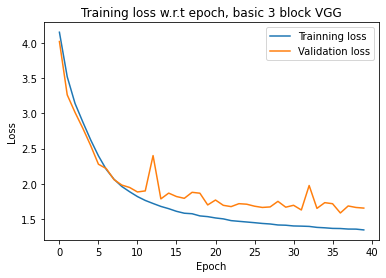

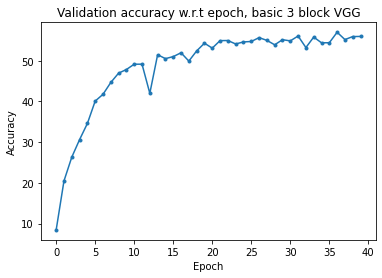

In [10]:
plt.figure(1)
plt.plot(loss_store_train,label = 'Trainning loss')
plt.plot(loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, basic 3 block VGG') 
plt.figure(2)
plt.plot(acc_store,marker='.')
plt.title('Validation accuracy w.r.t epoch, basic 3 block VGG') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')